#### free test

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from scipy import optimize
import glob
from pprint import pprint
import matplotlib.cm as cm

import sys
sys.path.append("../") # homeディレクトリをpathに追加

---
- optunaのdb確認

In [79]:
import sqlite3

# データベースファイルへのパス
db_path = '../output/2_28_opt_params3/simulation/optimize.db'

# データベースへ接続
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# テーブルの一覧を取得
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables:", tables)

# 各テーブルの内容を表示
for table in tables:
    table_name = table[0]
    print(f"\nContents of table '{table_name}':")
    cursor.execute(f"SELECT * FROM {table_name}")
    rows = cursor.fetchall()
    
    # カラム名も取得
    column_names = [description[0] for description in cursor.description]
    print("Columns:", column_names)
    
    # 各行の内容を表示
    for row in rows:
        print(row)

# データベース接続を閉じる
conn.close()

Tables: [('studies',), ('version_info',), ('study_directions',), ('study_user_attributes',), ('study_system_attributes',), ('trials',), ('trial_user_attributes',), ('trial_system_attributes',), ('trial_params',), ('trial_values',), ('trial_intermediate_values',), ('trial_heartbeats',), ('alembic_version',)]

Contents of table 'studies':
Columns: ['study_id', 'study_name']
(1, 'GasAdsorption')

Contents of table 'version_info':
Columns: ['version_info_id', 'schema_version', 'library_version']
(1, 12, '2.10.0')

Contents of table 'study_directions':
Columns: ['study_direction_id', 'direction', 'study_id', 'objective']
(1, 'MINIMIZE', 1, 0)

Contents of table 'study_user_attributes':
Columns: ['study_user_attribute_id', 'study_id', 'key', 'value_json']

Contents of table 'study_system_attributes':
Columns: ['study_system_attribute_id', 'study_id', 'key', 'value_json']

Contents of table 'trials':
Columns: ['trial_id', 'number', 'study_id', 'state', 'datetime_start', 'datetime_complete']
(

---
- DTW計算

In [82]:
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
# DTWリスト
df_sim = pd.read_csv("../output/2_28_opt_params2/simulation/csv/セクション到達温度.csv",
                index_col=0)
df_obs = pd.read_csv("../data/吸着のみ_弁停止フラグ.csv", index_col=0)

common_index = [np.argmin(np.abs(df_obs.index[i] - df_sim.index)) for i in range(len(df_obs.index))]
df_sim = df_sim.iloc[common_index]
df_sim = df_sim[["temp_reached_001_002", "temp_reached_001_010", "temp_reached_001_018",
                "temp_reached_002_002", "temp_reached_002_010", "temp_reached_002_018"]]
rename_cols = [f"temp_{str(stream).zfill(3)}_{str(section).zfill(3)}" for stream in [1,2] for section in [1,2,3]]
df_sim.columns = rename_cols

# DTWを計算
score_list = []
for col in rename_cols:
    score, _ = fastdtw(df_sim[col], df_obs[col], dist=euclidean)
    score_list.append(score)
print("DTW:", np.mean(score_list))
print("", score_list)
# RMSEを計算
score_list = []
for col in rename_cols:
    score = mean_squared_error(df_sim[col], df_obs[col], squared=False)
    score_list.append(score)
print("RMSE:", np.mean(score_list))
print("", score_list)

DTW: 334.42304440358754
 [363.7330656037489, 335.11681483665643, 181.73798202575992, 728.4406128652529, 195.02979408057388, 202.4799970095333]
RMSE: 2.2998571572826143
 [3.1645039011526577, 1.7881652778015493, 1.8744886814064774, 3.5462075150358365, 1.9586488455036344, 1.4671287227955283]


DTW:  119.54107080581497
RMSE:  12.056792688117559


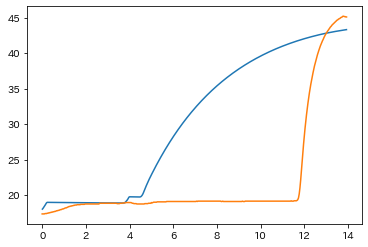

In [75]:
tgt_col = "temp_002_003"
print("DTW: ", fastdtw(df_sim[tgt_col], df_obs[tgt_col], dist=euclidean)[0])
print("RMSE: ",mean_squared_error(df_sim[tgt_col], df_obs[tgt_col], squared=False))
plt.plot(df_sim[tgt_col])
plt.plot(df_obs[tgt_col])

---
- スライド用画像作成

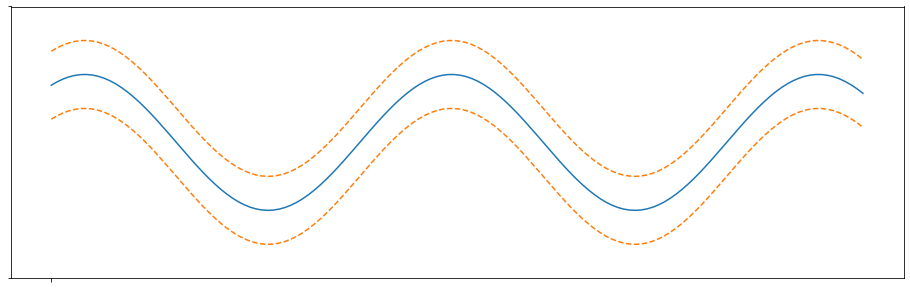

In [82]:
x = np.arange(1,15, 0.1)
f = lambda x: np.sin(x)
plt.figure(figsize=(16,5))
plt.plot(f(x))
plt.plot(f(x) + 0.5, linestyle="--", color="tab:orange")
plt.plot(f(x) - 0.5, linestyle="--", color="tab:orange")
plt.xticks([0])
plt.yticks([-2,2])
plt.tick_params(labelbottom=False, labelleft=False)
# plt.title("状態変数の推定値")
plt.show()

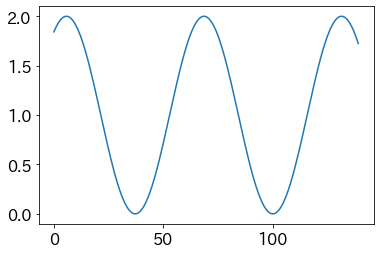

In [30]:
plt.plot(1 + np.sin(x))

---
- 2_27改修に伴うテスト

In [22]:
import glob

file_list = glob.glob("../output/2_26_change_data/simulation/csv/*.csv")

bool_list = []
for filepath in file_list:
    df_1 = pd.read_csv(f"../output/2_26_change_data/simulation/csv/{filepath[42:]}",
                    index_col=0)
    df_2 = pd.read_csv(f"../output/2_27_mod_heat_transfer_coef/simulation/csv/{filepath[42:]}",
                    index_col=0)
    bool_list.append(np.all(df_1 == df_2))
np.all(bool_list)

True

---

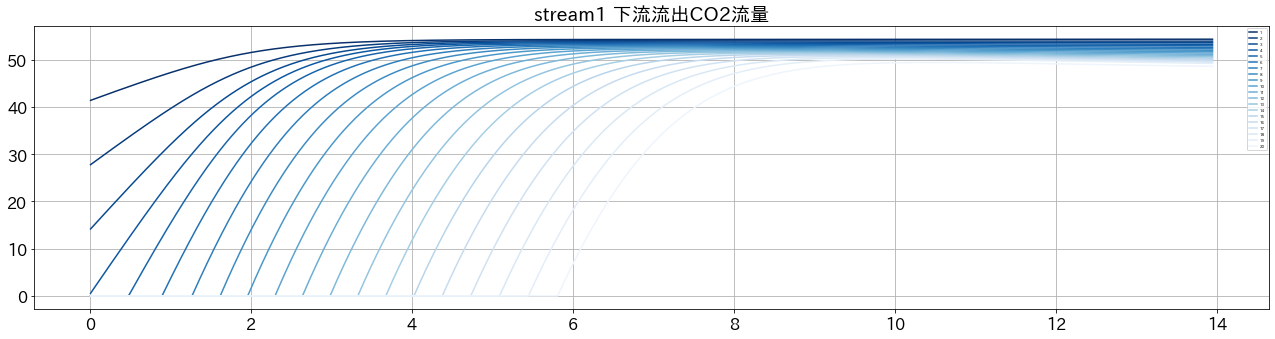

In [6]:
tgt = "下流流出CO2流量"
df = pd.read_csv(f"../output/2_21_mod_adsorp_amt/simulation/csv/{tgt}.csv",
                 index_col="timestamp")

tgt_cols_1 = [col for col in df.columns if col.split("_")[-2][-1] == "1"]
tgt_cols_2 = [col for col in df.columns if col.split("_")[-2][-1] == "2"]
tgt_cols_3 = [col for col in df.columns if col.split("_")[-2][-1] == "3"]
fig = plt.figure(figsize=(18, 5), tight_layout=True)
fig.patch.set_facecolor('white')
plt.rcParams["font.size"] = 16
for i in range(len(tgt_cols_1)):
    plt.plot(df[tgt_cols_1[i]], label=i+1, color=cm.Blues_r(i/len(tgt_cols_1)))
    # plt.plot(df[tgt_cols_2[i]], label=i+1, color=cm.Blues_r(i/len(tgt_cols_2)))
    # plt.plot(df[tgt_cols_3[i]], label=i+1, color=cm.Greens_r(i/len(tgt_cols_3)))
plt.legend(fontsize=4)
plt.grid()
# plt.xlim([-0.5, 2])
# plt.ylim([17.9, 18.3])
plt.title(f"stream1 {tgt}")
plt.show()

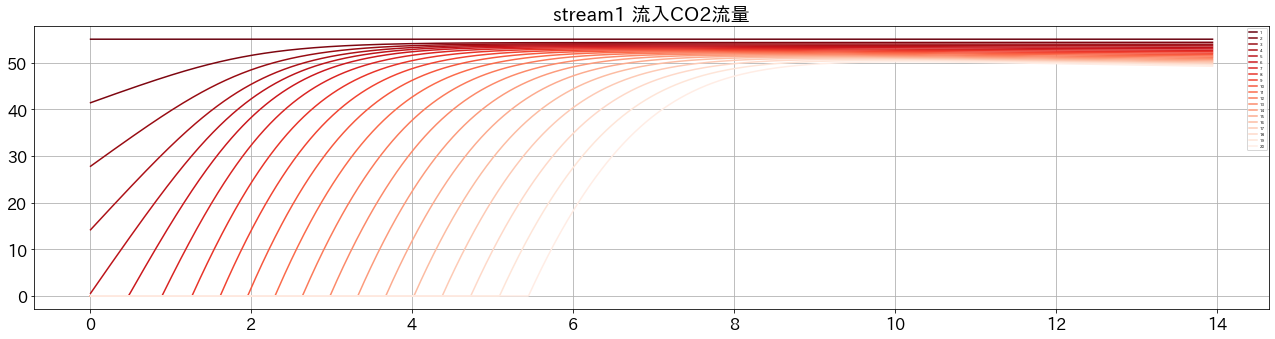

In [23]:
tgt = "流入CO2流量"
df = pd.read_csv(f"../output/2_21_mod_adsorp_amt/simulation/csv/{tgt}.csv",
                 index_col="timestamp")

tgt_cols_1 = [col for col in df.columns if col.split("_")[-2][-1] == "1"]
tgt_cols_2 = [col for col in df.columns if col.split("_")[-2][-1] == "2"]
tgt_cols_3 = [col for col in df.columns if col.split("_")[-2][-1] == "3"]
fig = plt.figure(figsize=(18, 5), tight_layout=True)
fig.patch.set_facecolor('white')
plt.rcParams["font.size"] = 16
for i in range(len(tgt_cols_1)):
    plt.plot(df[tgt_cols_1[i]], label=i+1, color=cm.Reds_r(i/len(tgt_cols_1)))
    # plt.plot(df[tgt_cols_2[i]], label=i+1, color=cm.Blues_r(i/len(tgt_cols_2)))
    # plt.plot(df[tgt_cols_3[i]], label=i+1, color=cm.Greens_r(i/len(tgt_cols_3)))
plt.legend(fontsize=4)
plt.grid()
# plt.xlim([-0.5, 2])
# plt.ylim([17.9, 18.3])
plt.title(f"stream1 {tgt}")
plt.show()

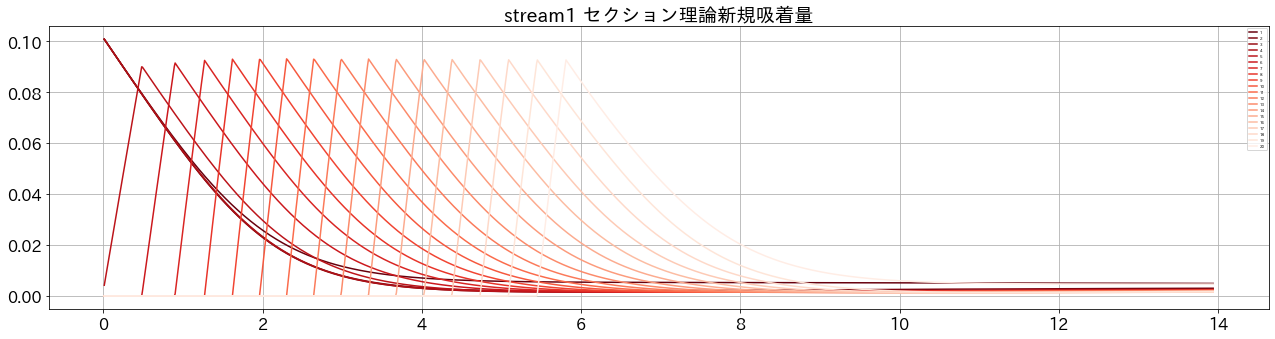

In [24]:
tgt = "セクション理論新規吸着量"
df = pd.read_csv(f"../output/2_21_mod_adsorp_amt/simulation/csv/{tgt}.csv",
                 index_col="timestamp")

tgt_cols_1 = [col for col in df.columns if col.split("_")[-2][-1] == "1"]
tgt_cols_2 = [col for col in df.columns if col.split("_")[-2][-1] == "2"]
tgt_cols_3 = [col for col in df.columns if col.split("_")[-2][-1] == "3"]
fig = plt.figure(figsize=(18, 5), tight_layout=True)
fig.patch.set_facecolor('white')
plt.rcParams["font.size"] = 16
for i in range(len(tgt_cols_1)):
    plt.plot(df[tgt_cols_1[i]], label=i+1, color=cm.Reds_r(i/len(tgt_cols_1)))
    # plt.plot(df[tgt_cols_2[i]], label=i+1, color=cm.Blues_r(i/len(tgt_cols_2)))
    # plt.plot(df[tgt_cols_3[i]], label=i+1, color=cm.Greens_r(i/len(tgt_cols_3)))
plt.legend(fontsize=4)
plt.grid()
# plt.xlim([-0.5, 2])
# plt.ylim([17.9, 18.3])
plt.title(f"stream1 {tgt}")
plt.show()